# Flux Divergence Calculations

David Shean  
April 21, 2020

## To do
* Add debris mask
* Revisit -vy issues
* Explore scale issues - 30 m vs. 100 m pixels
* Filter sizes - function of ice thickness
* Fill H and vx/vy with 0, do gradient, then mask

In [1]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
#%matplotlib notebook

In [3]:
def add_quiver(ax, vx, vy, stride=5, color='dodgerblue'):
    X = np.arange(0,vx.shape[1],stride)
    Y = np.arange(0,vx.shape[0],stride)
    ax.quiver(X, Y, vx[::stride,::stride], vy[::stride,::stride], color=color, pivot='mid')

### Shean Ngozumpa sample

In [77]:
#Data for Ngozumpa with Nov 8, 2018 timestamp - earlier run of mb_parallel.py
%cd /scr/hma/testcase/mb
fn_prefix = '15.03473_'

H_fn = fn_prefix+'H.tif'
H_ds = rio.open(H_fn)
H = rio.open(H_fn).read(1, masked=True)

vx_fn = fn_prefix+'vx.tif'
vy_fn = fn_prefix+'vy.tif'
vx = rio.open(vx_fn).read(1, masked=True)
vy = rio.open(vy_fn).read(1, masked=True)
vm = np.sqrt(vx*vx + vy*vy)

h_fn = fn_prefix+'z2.tif'
h = rio.open(h_fn).read(1, masked=True)

dhdt_fn = fn_prefix+'dz.tif'
dhdt = rio.open(dhdt_fn).read(1, masked=True)
dhdt /= 18.0

/scr/hma/testcase/mb


### Rounce Ngozumpa sample

In [78]:
%cd /scr/hma/testcase/ngozumpa_20200422_update
fn_prefix = '15.03473-'

H_fn = fn_prefix+'H.tif'
H_ds = rio.open(H_fn)
H = rio.open(H_fn).read(1, masked=True)

#vm_fn = fn_prefix+'vm.tif'
#vm = rio.open(vm_fn).read(1, masked=True)

vx_fn = fn_prefix+'vx.tif'
vy_fn = fn_prefix+'vy.tif'
vx = rio.open(vx_fn).read(1, masked=True)
vy = rio.open(vy_fn).read(1, masked=True)
#Deal with origin issues for array (lower right) vs. GDAL/GeoTiff (upper left) 
#vy *= -1
vm = np.sqrt(vx*vx + vy*vy)

h_fn = fn_prefix+'z1.tif'
h = rio.open(h_fn).read(1, masked=True)

dhdt_fn = fn_prefix+'dhdt.tif'
dhdt = rio.open(dhdt_fn).read(1, masked=True)

/scr/hma/testcase/ngozumpa_20200422_update


### Shean other samples

In [6]:
#Baltoro
fn_prefix = '13.04960_'
#Khumbu
fn_prefix = '15.03733_'
#Lhotse-star?
#fn_prefix = '15.03743_'

In [7]:
%cd /scr/hma/mb_20181211/rgi

H_fn = fn_prefix+'H.tif'
H_ds = rio.open(H_fn)
H = rio.open(H_fn).read(1, masked=True)

vx_fn = fn_prefix+'vx.tif'
vy_fn = fn_prefix+'vy.tif'
vx = rio.open(vx_fn).read(1, masked=True)
vy = rio.open(vy_fn).read(1, masked=True)
vm = np.sqrt(vx*vx + vy*vy)

h_fn = fn_prefix+'z2.tif'
h = rio.open(h_fn).read(1, masked=True)

dhdt_fn = fn_prefix+'dz.tif'
dhdt = rio.open(dhdt_fn).read(1, masked=True)
dhdt /= 18.0

/scr/hma/mb_20181211/rgi


In [79]:
#Raster cell size in meters
dx,dy = H_ds.res
print(dx)

65.0


In [80]:
#Scaling factor to obtain column-average velocity from surface velocity
v_col_f = 0.8

In [81]:
def imshow_stretch(ax,a,clim=None,perc=(2,98),sym=False,cmap='inferno',dx=dx):
    if sym:
        cmap = 'RdBu'
    if clim is None:
        vmin,vmax = np.percentile(a.compressed(),perc)
        #vmin,vmax = np.percentile(a,perc)
        if sym:
            vmax = np.max(np.abs([vmin,vmax]))
            vmin = -vmax
        clim = (vmin, vmax)
    m = ax.imshow(a, vmin=clim[0], vmax=clim[1], cmap=cmap)
    ax.add_artist(ScaleBar(dx))
    plt.colorbar(m, ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('0.5')
    return clim

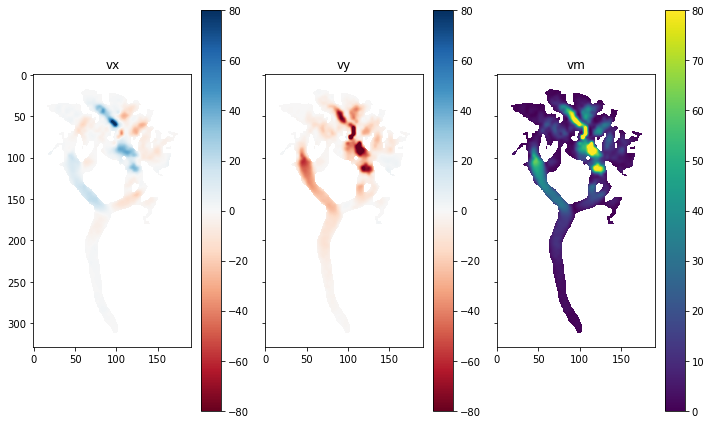

In [82]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,6))
lim = 80
m = axa[0].imshow(vx, vmin=-lim, vmax=lim, cmap='RdBu')
axa[0].set_title('vx')
plt.colorbar(m, ax=axa[0])
m = axa[1].imshow(vy, vmin=-lim, vmax=lim, cmap='RdBu')
axa[1].set_title('vy')
plt.colorbar(m, ax=axa[1])
m = axa[2].imshow(vm, vmin=0, vmax=lim)
axa[2].set_title('vm')
plt.colorbar(m, ax=axa[2])
plt.tight_layout()

## Simple Flux
Scalar thickness multiplied by velocity vector

In [83]:
Q = H * v_col_f * np.array([vx, -vy])

In [84]:
Qm = np.sqrt(np.sum(Q**2, axis=0))
#Qm = H * v_col_f * vm

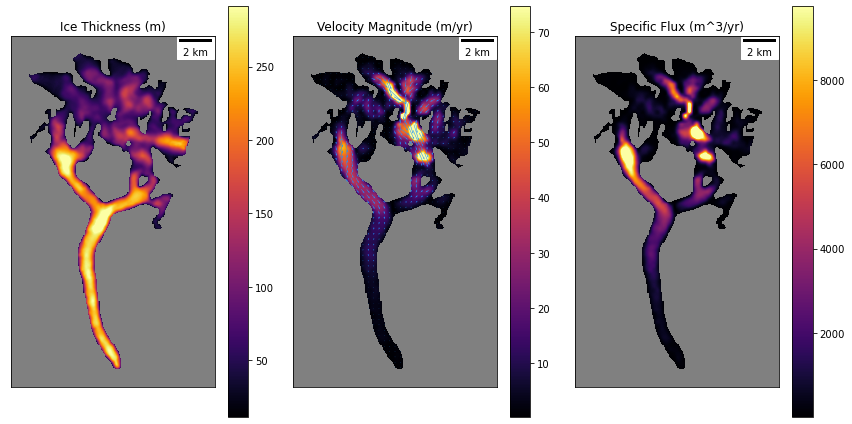

In [85]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,6))
axa[0].set_title('Ice Thickness (m)')
imshow_stretch(axa[0],H)
axa[1].set_title('Velocity Magnitude (m/yr)')
imshow_stretch(axa[1],vm)
add_quiver(axa[1],vx,vy)
axa[2].set_title('Specific Flux (m^3/yr)')
imshow_stretch(axa[2],Qm)
plt.tight_layout()

Ice thickness grid contains some artifacts near edges

## Flux divergence

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/b95fd343e0fe05b65d6096aa75a6c0921c33176d)

#### np.gradient

https://numpy.org/doc/stable/reference/generated/numpy.gradient.html

*Note: np.gradient computes derivatives relative to axis number, so (dy,dx) corresponod to axes (0,1)*

In [86]:
eo = 1

In [87]:
#Want x-derivative of x component
divQ = np.gradient(Q[0],dx,axis=1) + np.gradient(Q[1],dy,axis=0,edge_order=eo)

## Velocity divergence

In [88]:
divV = np.gradient(v_col_f*vx,dx,axis=1,edge_order=eo) + np.gradient(v_col_f*-vy,dy,axis=0,edge_order=eo)

In [89]:
#divVm = np.sqrt(np.gradient(v_col_f*vx)[1]**2 + np.gradient(v_col_f*vy)[0]**2)

## Thickness gradient

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7a948b9d1165bf36e01ff46716000a06b34dd801)

In [90]:
#Return both dy and dx derivatives
gradH = np.ma.array(np.gradient(H,dx,dy,edge_order=eo))

In [91]:
#Thickness difference between adjacent cells (not accounting for cell width and height, 30 m)
#gradH = np.ma.array(np.gradient(H,1,1))

In [92]:
#Magnitude
gradHm = np.sqrt(np.sum(gradH**2, axis=0))

## Flux Divergence from Product Rule

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d631403ec94c0dd0f96a9cf45d59921b78e173f7)

* Thickness H is a scalar
* Velocity v is a vector (vx, vy)
* Gradient of thickness is a vector
* Divergence of velocity is a scalar

In [93]:
gradH_V = (gradH[1]*v_col_f*vx + gradH[0]*v_col_f*-vy)
H_divV = H*divV
divQ2 = gradH_V + H_divV

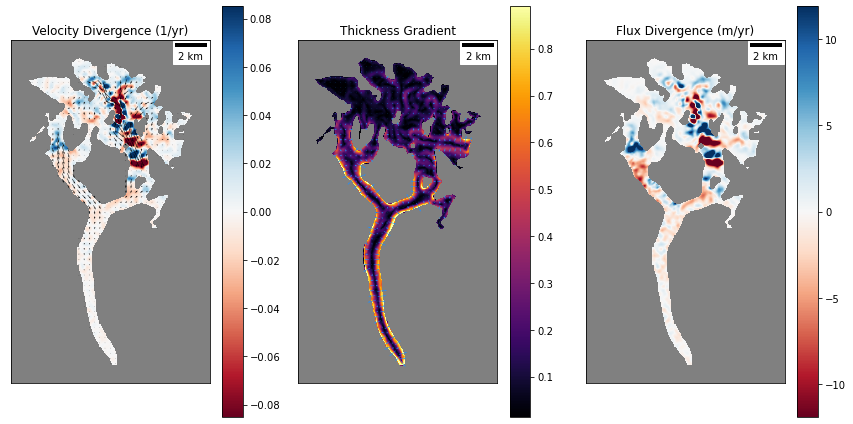

In [94]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,6))
axa[0].set_title('Velocity Divergence (1/yr)')
imshow_stretch(axa[0],divV,sym=True)
add_quiver(axa[0],vx,vy,color='k')
axa[1].set_title('Thickness Gradient')
imshow_stretch(axa[1],gradHm)
add_quiver(axa[1],-gradH[1],gradH[0])
axa[2].set_title('Flux Divergence (m/yr)')
imshow_stretch(axa[2], divQ2, sym=True)
plt.tight_layout()

### Notes
* Velocity divergence is positive when velocities are increasing (corresponding to thinning)
* Velocity divergence is negative when velocities are decreasing (corresponding to thickening)

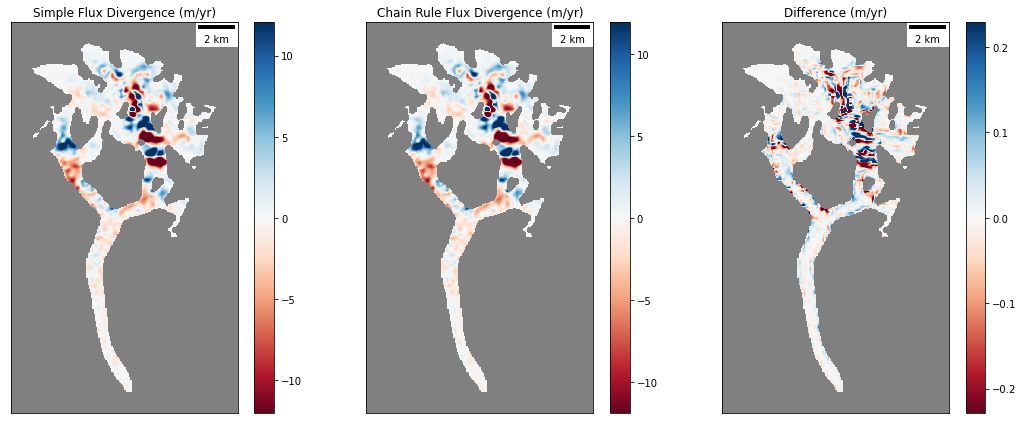

In [95]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,6))
axa[0].set_title('Simple Flux Divergence (m/yr)')
imshow_stretch(axa[0], divQ, sym=True)
axa[1].set_title('Chain Rule Flux Divergence (m/yr)')
imshow_stretch(axa[1], divQ2, sym=True)
axa[2].set_title('Difference (m/yr)')
imshow_stretch(axa[2], divQ-divQ2, sym=True)
plt.tight_layout()

## Isolating components of flux divergence

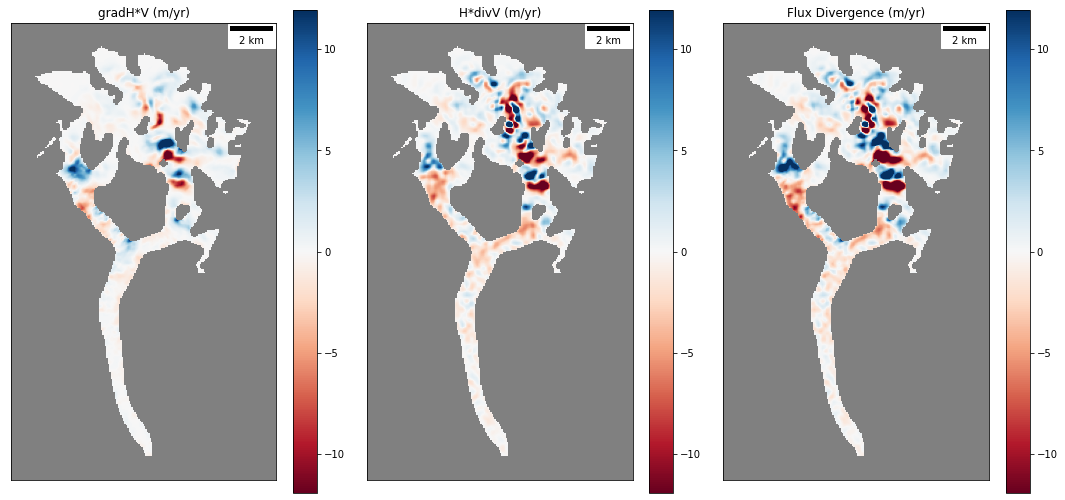

In [96]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,7))
axa[2].set_title('Flux Divergence (m/yr)')
clim = imshow_stretch(axa[2], divQ2, sym=True)
axa[0].set_title('gradH*V (m/yr)')
imshow_stretch(axa[0],gradH_V,clim=clim,sym=True)
axa[1].set_title('H*divV (m/yr)')
imshow_stretch(axa[1],H_divV,clim=clim,sym=True)
plt.tight_layout()

In [97]:
gradHm.mean()

0.2272501375380658

In [98]:
vm.mean()

13.24077353154836

In [99]:
gradH_V.mean()

0.19733766026420788

In [100]:
H.mean()

113.36652483741526

In [101]:
divV.mean()

-6.3355489532913765e-06

In [102]:
H_divV.mean()

-0.1881512063911055

### Notes

## Lagrangian analysis of H and h

In [103]:
#Generate coordinate arrays for surface elevation
ix,iy = np.ma.array(np.meshgrid(np.arange(h.shape[1]), np.arange(h.shape[0])))
ix = np.ma.array(ix, mask=np.ma.getmaskarray(h))
iy = np.ma.array(iy, mask=np.ma.getmaskarray(h))

In [104]:
#Length of time
dt = 1 #year
#Determine new coordiantes for known velocity
ix2 = ix + (vx/dx)*dt
iy2 = iy + (-vy/dy)*dt

In [105]:
import scipy.ndimage

In [106]:
yx = np.array([iy2.compressed(),ix2.compressed()])

In [107]:
#Use bilinear resampling here (order=1)
h2_samp = scipy.ndimage.map_coordinates(h, yx, order=1,mode='nearest')
H2_samp = scipy.ndimage.map_coordinates(H, yx, order=1,mode='nearest')

In [108]:
#Populate new arrays with sampled values
h2 = np.zeros_like(h)
h2[iy.compressed(),ix.compressed()] = h2_samp
H2 = np.zeros_like(H)
H2[iy.compressed(),ix.compressed()] = H2_samp

## Notes
* Compute observed lag elev change, sampling from real h2
* Compare observed with predicted
* map_coordinates has edge artifacts due to filling 0 in surface elevation, even when using `mode='nearest'`

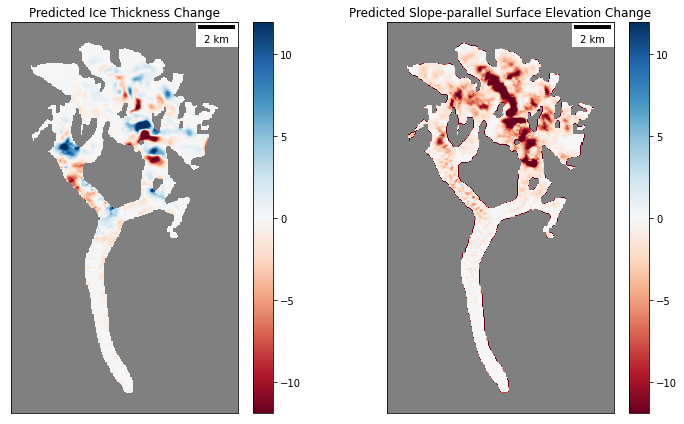

In [109]:
f,axa = plt.subplots(1,2, figsize=(10,6))
clim = imshow_stretch(axa[0], H2-H, clim=clim, sym=True)
axa[0].set_title('Predicted Ice Thickness Change')
imshow_stretch(axa[1], h2-h, clim=clim, sym=True)
axa[1].set_title('Predicted Slope-parallel Surface Elevation Change')
plt.tight_layout()

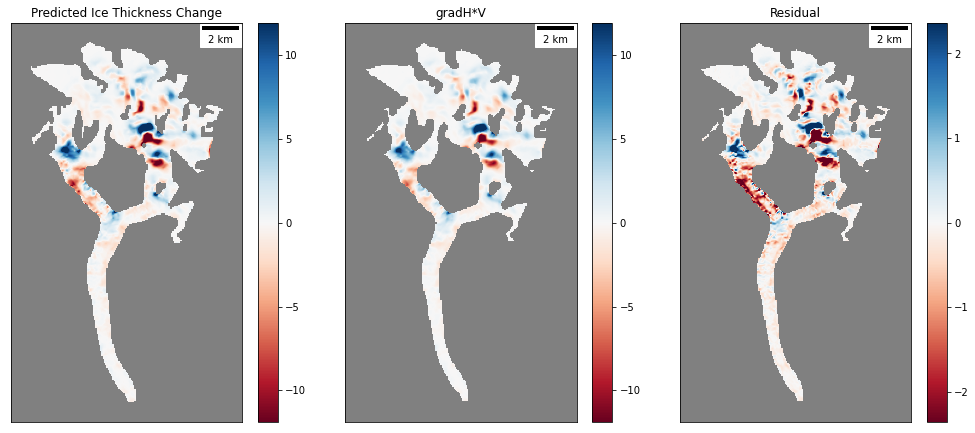

In [110]:
f,axa = plt.subplots(1,3, figsize=(14,6))
clim = imshow_stretch(axa[0], H2-H, clim=clim, sym=True)
axa[0].set_title('Predicted Ice Thickness Change')
imshow_stretch(axa[1], gradH_V, clim=clim, sym=True)
axa[1].set_title('gradH*V')
imshow_stretch(axa[2], (H2-H) - gradH_V, sym=True)
axa[2].set_title('Residual')
plt.tight_layout()

## Emergence velocity

In [111]:
vv = -divQ2

(-11.908233871459936, 11.908233871459936)

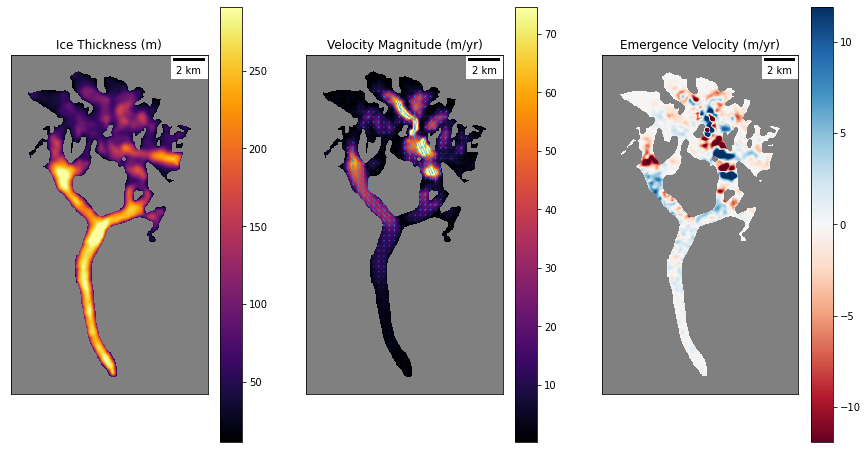

In [112]:
f,axa = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,8))
axa[0].set_title('Ice Thickness (m)')
imshow_stretch(axa[0],H)
axa[1].set_title('Velocity Magnitude (m/yr)')
imshow_stretch(axa[1],vm)
add_quiver(axa[1],vx,vy)
axa[2].set_title('Emergence Velocity (m/yr)')
imshow_stretch(axa[2], vv, sym=True)

## Sanity check on vectors

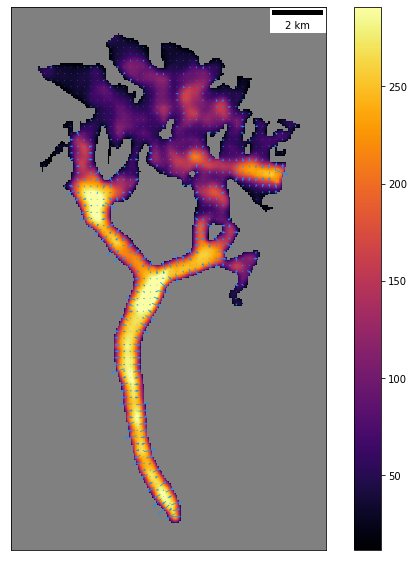

In [113]:
f,ax = plt.subplots(figsize=(10,10))
imshow_stretch(ax,H)
#Need negative sign on the x values here to get vectors aligned properly along steepest gradient
add_quiver(ax,-gradH[1],gradH[0],stride=4)

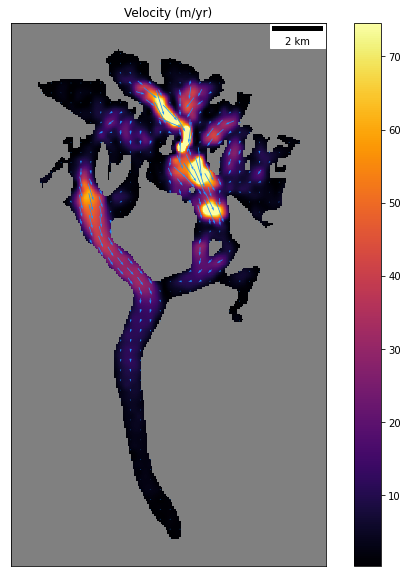

In [114]:
f,ax = plt.subplots(figsize=(10,10))
ax.set_title('Velocity (m/yr)')
imshow_stretch(ax,vm)
add_quiver(ax,vx,vy,stride=6)

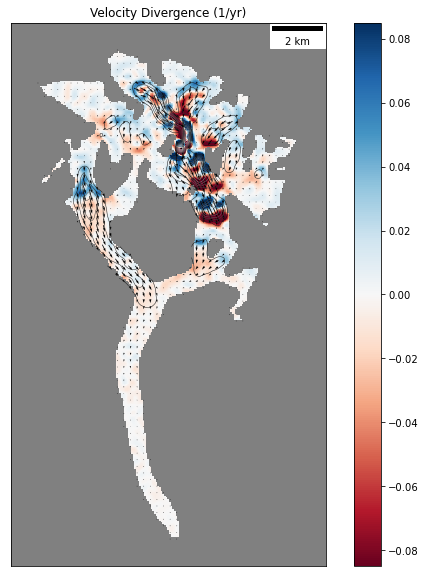

In [115]:
f,ax = plt.subplots(figsize=(10,10))
ax.set_title('Velocity Divergence (1/yr)')
imshow_stretch(ax,divV,sym=True)
add_quiver(ax,vx,vy,color='k',stride=4)
ax.contour(vm,10,linewidths=0.5,cmap='gray')

### Check for conservation

In [116]:
H.count()

14454

*Note: this is less than original due to edge issues with gradient - should fill with 0 prior to calculting*

In [117]:
divQ.count()

12846

In [118]:
divQ2.count()

12845

In [119]:
print('%0.2f%% of original pixels' % (100*divQ2.count()/H.count()))

88.87% of original pixels


In [120]:
divQ.sum()

121.74086

In [121]:
divQ2.sum()

117.99989

In [122]:
print('%0.2f%% leakage' % (100*divQ2.sum()/divQ2.count()))

0.92% leakage


## Surface Elevation

In [123]:
gradh = np.ma.array(np.gradient(h,dx,dy,edge_order=eo))

In [124]:
#Magnitude
gradhm = np.sqrt(np.sum(gradh**2, axis=0))

In [125]:
slope = np.rad2deg(np.arctan(gradhm))

## Binned values

In [126]:
bin_step = 50
bins = np.arange(h.min(),h.max()+bin_step,bin_step)
bin_centers = bins[:-1] + bin_step/2.

(1.2811621991511128, 48.46842237760605)

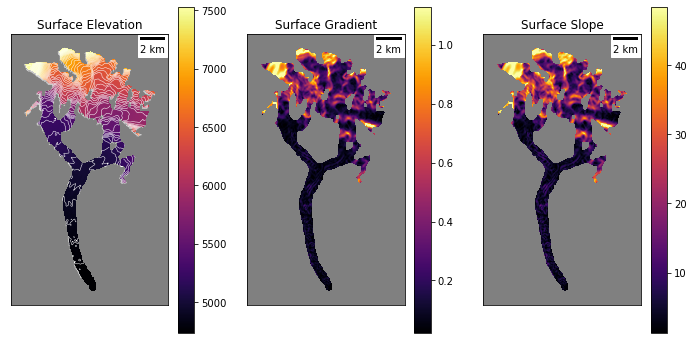

In [127]:
f,axa = plt.subplots(1,3,sharex=True, sharey=True, figsize=(12,6))
axa[0].set_title('Surface Elevation')
imshow_stretch(axa[0],h)
axa[0].contour(h,bins,colors='w',linewidths=0.5)
axa[1].set_title('Surface Gradient')
imshow_stretch(axa[1],gradhm)
axa[2].set_title('Surface Slope')
imshow_stretch(axa[2],slope)

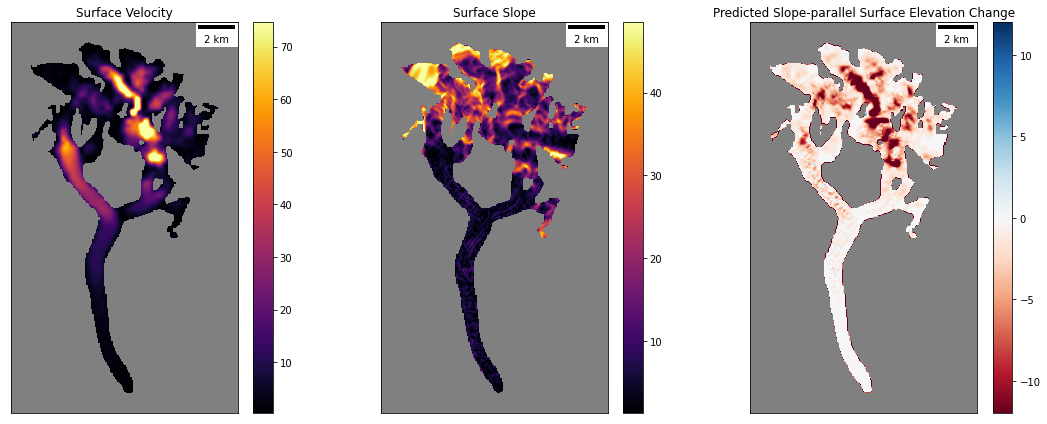

In [128]:
f,axa = plt.subplots(1,3,sharex=True, sharey=True, figsize=(15,6))
axa[0].set_title('Surface Velocity')
imshow_stretch(axa[0],vm)
axa[1].set_title('Surface Slope')
imshow_stretch(axa[1],slope)
axa[2].set_title('Predicted Slope-parallel Surface Elevation Change')
imshow_stretch(axa[2], h2-h, perc=(10,90), sym=True)
plt.tight_layout()

14454

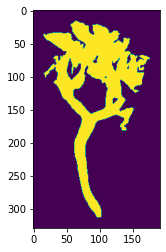

In [129]:
common_mask = np.ma.getmaskarray(np.ma.dstack([h,divQ2])).all(axis=-1)
idx = ~common_mask
f,ax = plt.subplots()
ax.imshow(idx)
idx.nonzero()[0].size

12845

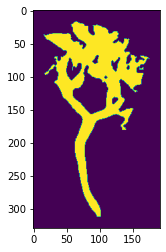

In [130]:
common_mask = np.ma.getmaskarray(np.ma.dstack([h,divQ2])).any(axis=-1)
idx = ~common_mask
f,ax = plt.subplots()
ax.imshow(idx)
idx.nonzero()[0].size

## Observed Elevation Change

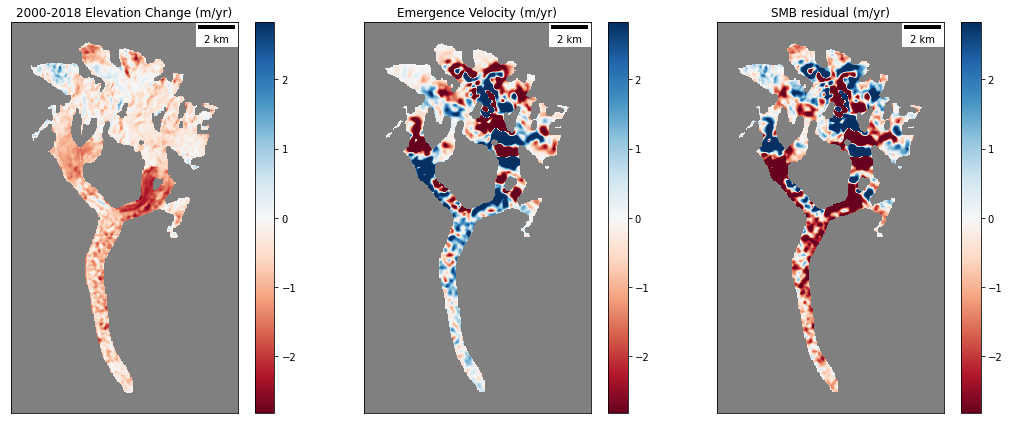

In [131]:
#clim = (-3,3)
f,axa = plt.subplots(1,3,figsize=(15,6))
axa[0].set_title('2000-2018 Elevation Change (m/yr)')
clim = imshow_stretch(axa[0],dhdt,perc=(0.01,99.99),sym=True)
#axa[0].contour(h,bins,colors='k',linewidths=0.5)
axa[1].set_title('Emergence Velocity (m/yr)')
imshow_stretch(axa[1],vv,clim=clim,sym=True)
#axa[1].contour(h,bins,colors='k',linewidths=0.5)
axa[2].set_title('SMB residual (m/yr)')
imshow_stretch(axa[2],dhdt-vv,clim=clim,sym=True)
#axa[2].contour(h,bins,colors='k',linewidths=0.5)
plt.tight_layout()

## Binned Statistics

In [132]:
def bin_stats(x,y):
    #bin_count = scipy.stats.binned_statistic(x,y,statistic='count',bins=bins)
    bin_mean = scipy.stats.binned_statistic(x,y,statistic='mean',bins=bins)
    bin_std = scipy.stats.binned_statistic(x,y,statistic='std',bins=bins)
    bin_med = scipy.stats.binned_statistic(x,y,statistic='median',bins=bins)
    bin_nmad = scipy.stats.binned_statistic(x,y,statistic=scipy.stats.median_absolute_deviation,bins=bins)
    return (bin_mean, bin_std, bin_med, bin_nmad)

In [133]:
vv_bin_mean, vv_bin_std, vv_bin_med, vv_bin_nmad = bin_stats(h[idx], vv[idx])
dhdt_bin_mean, dhdt_bin_std, dhdt_bin_med, dhdt_bin_nmad = bin_stats(h[idx], dhdt[idx])

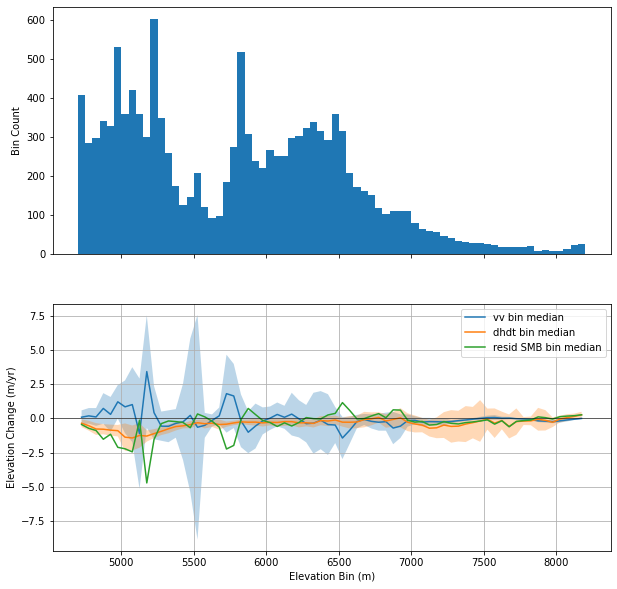

In [134]:
f,axa = plt.subplots(2,1,sharex=True,figsize=(10,10))
axa[0].hist(h[idx],bins=bins)
axa[0].set_ylabel('Bin Count')

#axa[1].plot(bin_centers, vv_bin_mean.statistic, label='vv bin mean')
#axa[1].fill_between(bin_centers, vv_bin_mean.statistic+vv_bin_std.statistic, vv_bin_mean.statistic-vv_bin_std.statistic, alpha=0.3)
axa[1].plot(bin_centers, vv_bin_med.statistic, label='vv bin median')
axa[1].fill_between(bin_centers, vv_bin_med.statistic+vv_bin_nmad.statistic, vv_bin_med.statistic-vv_bin_nmad.statistic, alpha=0.3)

#axa[1].plot(bin_centers, dhdt_bin_mean.statistic, label='dhdt bin mean')
#axa[1].fill_between(bin_centers, dhdt_bin_mean.statistic+dhdt_bin_std.statistic, dhdt_bin_mean.statistic-dhdt_bin_std.statistic, alpha=0.3)
axa[1].plot(bin_centers, dhdt_bin_med.statistic, label='dhdt bin median')
axa[1].fill_between(bin_centers, dhdt_bin_med.statistic+dhdt_bin_nmad.statistic, dhdt_bin_med.statistic-dhdt_bin_nmad.statistic, alpha=0.3)

axa[1].plot(bin_centers, dhdt_bin_med.statistic-vv_bin_med.statistic, label='resid SMB bin median')

axa[1].axhline(0,color='k',lw=0.5)
axa[1].set_ylabel('Elevation Change (m/yr)')
axa[1].set_xlabel('Elevation Bin (m)')
axa[1].legend()
axa[1].grid()
#axa[1].set_ylim(-5,5)

## Filtering/smoothing

In [135]:
from pygeotools.lib import filtlib

In [136]:
size=9
sigma=None
h_smooth = filtlib.gauss_fltr_astropy(h,size=size,sigma=sigma,origmask=True)
dhdt_smooth = filtlib.gauss_fltr_astropy(dhdt,size=size,sigma=sigma,origmask=True)
vv_smooth = filtlib.gauss_fltr_astropy(vv,size=size,sigma=sigma,origmask=True)

Applying gaussian smoothing filter with size 9 and sigma 1.333 (sum 0.999)
Applying original mask
Applying gaussian smoothing filter with size 9 and sigma 1.333 (sum 0.999)
Applying original mask
Applying gaussian smoothing filter with size 9 and sigma 1.333 (sum 0.999)
Applying original mask


In [140]:
#h_smooth = filtlib.median_fltr(h)
#dhdt_smooth = filtlib.median_fltr(dhdt)
#vv_smooth = filtlib.median_fltr(vv)

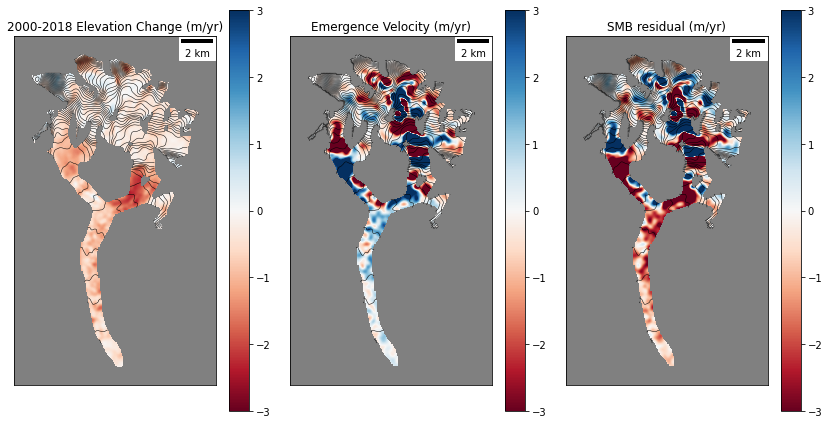

In [141]:
clim = (-3,3)
f,axa = plt.subplots(1,3,figsize=(12,6))
axa[0].set_title('2000-2018 Elevation Change (m/yr)')
imshow_stretch(axa[0],dhdt_smooth,clim=clim,sym=True)
axa[0].contour(h_smooth,bins,colors='k',linewidths=0.5)
axa[1].set_title('Emergence Velocity (m/yr)')
imshow_stretch(axa[1],vv_smooth,clim=clim,sym=True)
axa[1].contour(h_smooth,bins,colors='k',linewidths=0.5)
axa[2].set_title('SMB residual (m/yr)')
imshow_stretch(axa[2],dhdt_smooth-vv_smooth,clim=clim,sym=True)
axa[2].contour(h_smooth,bins,colors='k',linewidths=0.5)
plt.tight_layout()

In [142]:
vv_bin_mean, vv_bin_std, vv_bin_med, vv_bin_nmad = bin_stats(h[idx], vv_smooth[idx])
dhdt_bin_mean, dhdt_bin_std, dhdt_bin_med, dhdt_bin_nmad = bin_stats(h[idx], dhdt_smooth[idx])

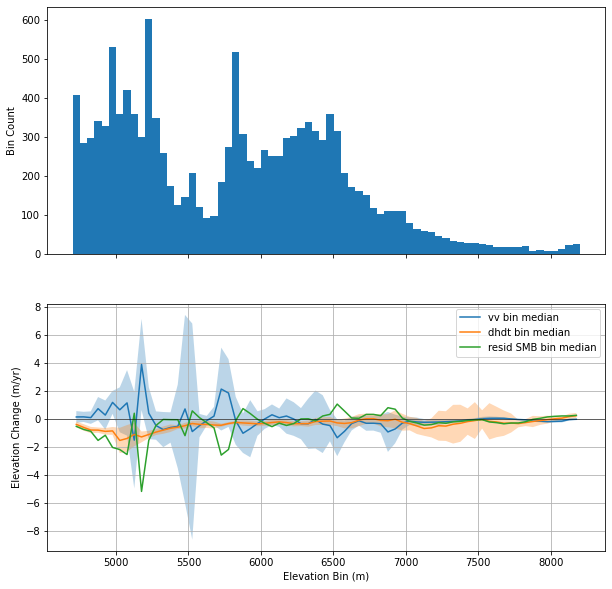

In [143]:
f,axa = plt.subplots(2,1,sharex=True,figsize=(10,10))
axa[0].hist(h[idx],bins=bins)
axa[0].set_ylabel('Bin Count')

#axa[1].plot(bin_centers, vv_bin_mean.statistic, label='vv bin mean')
#axa[1].fill_between(bin_centers, vv_bin_mean.statistic+vv_bin_std.statistic, vv_bin_mean.statistic-vv_bin_std.statistic, alpha=0.3)
axa[1].plot(bin_centers, vv_bin_med.statistic, label='vv bin median')
axa[1].fill_between(bin_centers, vv_bin_med.statistic+vv_bin_nmad.statistic, vv_bin_med.statistic-vv_bin_nmad.statistic, alpha=0.3)

#axa[1].plot(bin_centers, dhdt_bin_mean.statistic, label='dhdt bin mean')
#axa[1].fill_between(bin_centers, dhdt_bin_mean.statistic+dhdt_bin_std.statistic, dhdt_bin_mean.statistic-dhdt_bin_std.statistic, alpha=0.3)
axa[1].plot(bin_centers, dhdt_bin_med.statistic, label='dhdt bin median')
axa[1].fill_between(bin_centers, dhdt_bin_med.statistic+dhdt_bin_nmad.statistic, dhdt_bin_med.statistic-dhdt_bin_nmad.statistic, alpha=0.3)

axa[1].plot(bin_centers, dhdt_bin_med.statistic-vv_bin_med.statistic, label='resid SMB bin median')

axa[1].axhline(0,color='k',lw=0.5)
axa[1].set_ylabel('Elevation Change (m/yr)')
axa[1].set_xlabel('Elevation Bin (m)')
axa[1].legend()
axa[1].grid()
#axa[1].set_ylim(-5,5)